# Building conversational AI with the Rasa stack
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)


This noetbook is a basis for my workshop at PyData 2018 Berlin. If you have any questions or would like to learn more about anything included in this notebook, please let me know or get in touch by juste@rasa.com.

In this workshop we are going to build a chatbot capable of checking in on people's mood and take the necessary actions to cheer them up. 


The tutorial consists of three parts:


*   Part 0: Installation and setup
*   Part 1: Teaching the bot to understand user inputs using Rasa NLU model
*   Part 2: Teaching the bot to handle multi-turn conversations using dialogue management model.
*   Part 3: Resources and tips

## Part 0: Installation

### Let's start with jupyter configuration

In [ ]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Installation of Rasa
Let's start with the installation of Rasa NLU, Rasa Core and a spacy language model. If you have already installed, you can skip this step. 

In [ ]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core==0.9.6 rasa_nlu[spacy];

# as well as install a language model:
!{python} -m spacy download en_core_web_md
!{python} -m spacy link en_core_web_md en --force;

Let's test the installation - we should have rasa_nlu: 0.12.3 and rasa_core: 0.9.6 installed, and spacy model should be available.

In [ ]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

### Some additional Tools needed
To do some of the visualizations you will also need graphviz. If you don't have graphviz installed, and this doesn't work: don't worry. I'll show you the graph and besides that visualization everything else will work.

Try installing with anyone of these (or adapt to your operating system):

In [ ]:
!sudo apt-get install graphviz libgraphviz-dev pkg-config

and another python package and we are ready to go:

In [ ]:
!{python} -m pip install pygraphviz;

## Part 1: Natural Language Understanding

At first, let's teach our chatbot how to understand user inputs. To do that, we are going to build a Rasa NLU model. 

### Creating the training data for language understanding


Lets create some training data here, grouping user messages by their `intents`. The intent describes what the messages *mean*. Another important part of training data are `entities` - pieces of information which help a chatbot understand what specifically a user is asking about. Entities are labeled using the markdown link syntex: `[entity value](entity_type)` [More information about the data format](https://nlu.rasa.com/dataformat.html#markdown-format).

In [ ]:
nlu_md = """
## intent:greet
- hey
- hello there
- hi
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- feeling like a king
- wonderful
- I am feeling very good
- I am great
- I am amazing
- I am going to save the world
- super
- extremely good
- so so perfect
- so good
- so perfect

## intent:mood_unhappy
- my day was horrible
- I am sad
- I don't feel very well
- I am disappointed
- super sad
- I'm so sad
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not so good
- not very good
- extremly sad
- so saad
- so sad. Only the picture of a [puppy](group:shibes) could make it better.
- I am very sad. I need a [cat](group:cats) picture.
- Extremely sad. Only the cute [doggo](group:shibes) pics can make me feel better.
- Bad. Please show me a [bird](group:birds) pic!
- Pretty bad to be honest. Can you show me a [puppy](group:shibes) picture to make me fell better?

## intent: infrom
- A [dog](group:shibes)
- [dog](group:shibes)
- [bird](group:birds)
- a [cat](group:cats)
- [cat](group:cats)
- a [bird](group:birds)
- of a [dog](group:shibes)
- of a [cat](group:cats)
- a [bird](group:birds), please
- a [dog](group:shibes), please



"""

%store nlu_md > nlu.md

### Defining the NLU model

Once the training data is ready, we can define our NLU model. We can do that by constructing the processing pipeline which defines how structured data is extracted from unstructured user inputs. 

In [ ]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"
""" 

%store config > config.yml

### Training the Rasa NLU Model

We're going to train a model to recognise user inputs, so that when you send a message like "hello" to your bot, it will recognise this as a `"greet"` intent.

In [ ]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

### Using & evaluating the NLU model

Let's see how the model is performing on some of the inputs:

In [104]:
pprint(interpreter.parse("Really really bad. All I need now is a cute picture of a doggo"))

{
  "intent": {
    "name": "mood_unhappy",
    "confidence": 0.5400934315828518
  },
  "entities": [
    {
      "start": 57,
      "end": 62,
      "value": "shibes",
      "entity": "group",
      "confidence": 0.8247777948616317,
      "extractor": "ner_crf",
      "processors": [
        "ner_synonyms"
      ]
    }
  ],
  "intent_ranking": [
    {
      "name": "mood_unhappy",
      "confidence": 0.5400934315828518
    },
    {
      "name": "mood_great",
      "confidence": 0.12164632728590866
    },
    {
      "name": "goodbye",
      "confidence": 0.11904527630527965
    },
    {
      "name": "mood_affirm",
      "confidence": 0.08772163357944629
    },
    {
      "name": "greet",
      "confidence": 0.05988315897851242
    },
    {
      "name": "infrom",
      "confidence": 0.04006762453598077
    },
    {
      "name": "mood_deny",
      "confidence": 0.03154254773202045
    }
  ],
  "text": "Really really bad. All I need now is a cute picture of a doggo"
}


Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 82 (7 distinct intents)
	- Found intents: 'mood_affirm', 'mood_deny', 'mood_unhappy', 'greet', 'infrom', 'mood_great', 'goodbye'
	- entity examples: 15 (1 distinct entities)
	- found entities: 'group'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 82 examples that have a defined intent out of 82 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9089646873698338
INFO:rasa_nlu.evaluate:Precision: 0.9247967479674798
INFO:rasa_nlu.evaluate:Accuracy:  0.9146341463414634
INFO:rasa_nlu.evaluate:Classification report: 
              precision    recall  f1-score   support

     goodbye       0.83      0.45      0.59        11
       greet       0.67      0.92      0.77        13
      infrom    

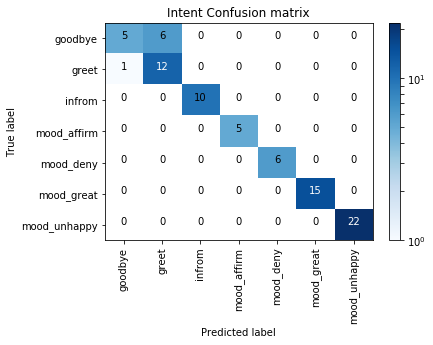

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  0.9729627235509589
INFO:rasa_nlu.evaluate:Precision: 0.9736322242152768
INFO:rasa_nlu.evaluate:Accuracy:  0.9747899159663865
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

      group       0.91      0.67      0.77        15
  no_entity       0.98      1.00      0.99       223

avg / total       0.97      0.97      0.97       238



In [107]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

# Part 2: Handling the dialogue

We have taught our chatbot how to understand user inputs. Now, it's time to teach our chatbot how to make responses by training a dialogue management model using Rasa Core.

### Writing Stories

The training data for dialogue management models is called `stories`. A story is an actual conversation where user inputs are expressed as intents as well as corresponding entities, and chatbot responses are expressed as actions.


Let's take a look into the format of the stories in more detail:

A story starts with `##` and you can give it a name. 
Lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

In [ ]:
stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - utter_ask_picture
* inform{"animal":"dog"}  
  - action_retrieve_image
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - utter_ask_picture
* inform{"group":"cat"}
  - action_retrieve_image
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## sad path 3
* greet
  - utter_greet
* mood_unhappy{"group":"puppy"}
  - action_retrieve_image
  - utter_did_that_help
* mood_affirm
  - utter_happy
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye

## fallback
- utter_unclear

"""

%store stories_md > stories.md

### Defining a Domain

The domain specifies the universe that the bot operates in. In chatbot's world this universe consists of intents and entities as well as the actions which appear in training stories. The domain can also contain the templates for the answers a chabot should use to reposond to the user and slots which will help the chatbot to keep track of the context. Let's look into the domain of our bot:

In [ ]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy
- inform

slots:
  group:
    type: text
  img_api_response:
    type: unfeaturized
    
entities:
- group

actions:
- utter_greet
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear
- utter_ask_picture
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
  
  utter_ask_picture:
  - text: "To cheer you up, I can show you a cute picture of a dog, cat or a bird. Which one do you choose?"
"""

%store domain_yml > domain.yml

### Adding Custom Actions

The responses of the chatbot can be more than just simple text responses - we can call an API to retrieve some data which can later be used to create a response to user input. Let's create a custom action for our bot which, when predicted, will make an API and retrieve a picture of a dog, a cat or a bird, debending on which was specified by the user. The bot will know which type of picture should be received by retreiving the value of the slot `group`.


In [ ]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet
from IPython.display import Image

import requests

class ApiAction(Action):
    def name(self):
        return "action_retrieve_image"

    def run(self, dispatcher, tracker, domain):
        
        group = tracker.get_slot('group')
        
        r = requests.get('http://shibe.online/api/{}?count=1&urls=true&httpsUrls=true'.format(group))
        url = json.loads(r.text)
        display(Image(str(url[0]), height=550, width=520))
        dispatcher.utter_message("Here is something to cheer you up!")

### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


Processed Story Blocks: 100%|██████████| 7/7 [00:00<00:00, 244.25it/s, # trackers=1]


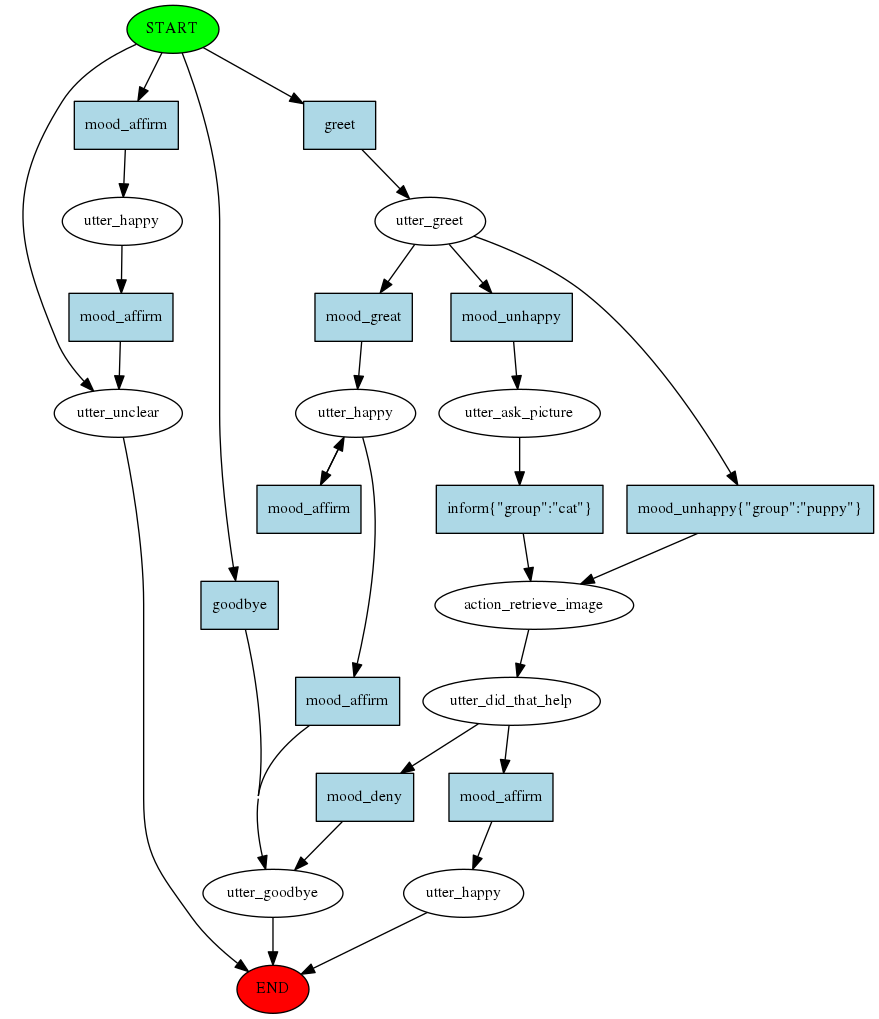

In [106]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

### Training your Dialogue Model

Now we are good to train the dialogue management model. We can specify what policies should be used to train it - in this case, the model is a neural network implemented in Keras which learns to predict which action to take next. We can also tweak the paramteres of what percentage of training examples should be used for validation and how many epochs should be used for training.

In [ ]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy()])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=400
)

agent.persist('models/dialogue')

### Starting up the bot (with NLU)

Now it's time for the fun part - starting the agent and chatting with it. We are going to start the `Agent` by loading our just trained dialogue model and using the previously trained nlu model as an interpreter for incoming user inputs.

In [ ]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

### Talking to the Bot (with NLU)

Let's have a chat!

Your bot is ready to talk! Type your messages here or send 'stop'
hello
Hey! How are you?
I am extremely sad
To cheer you up, I can show you a cute picture of a dog, cat or a bird. Which one do you choose?
A dog


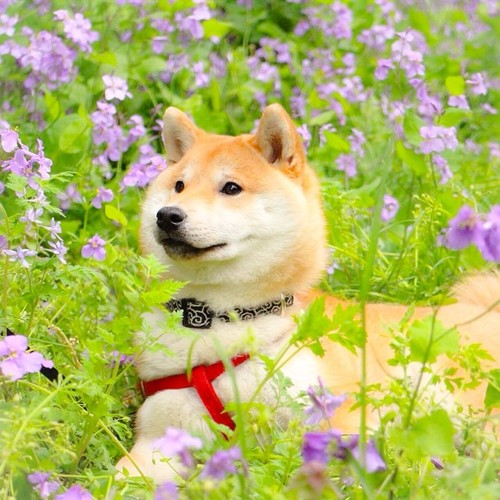

Here is something to cheer you up!
Did that help you?
Yes
Great carry on!
stop


In [102]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


### Evaluation of the dialogue model
As with the NLU model, instead of just subjectively testing the model, we can also evaluate the model on a dataset. You'll be using the training data set again, but usually you'd use a test data set separate from the training data.

Processed Story Blocks: 100%|██████████| 7/7 [00:00<00:00, 65390.04it/s]
INFO:rasa_core.evaluate:Evaluating 7 stories
Progress:
 14%|█▍        | 1/7 [00:01<00:06,  1.07s/it]ERROR:rasa_core.processor:Encountered an exception while running action 'action_retrieve_image'. Bot will continue, but the actions events are lost. Make sure to fix the exception in your custom code.
ERROR:rasa_core.processor:Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):
  File "/home/juste/anaconda3/lib/python3.6/site-packages/rasa_core/processor.py", line 302, in _run_action
    events = action.run(dispatcher, tracker, self.domain)
  File "<ipython-input-91-d4679d2639af>", line 15, in run
    url = json.loads(r.text)
  File "/home/juste/anaconda3/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/home/juste/anaconda3/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/home/

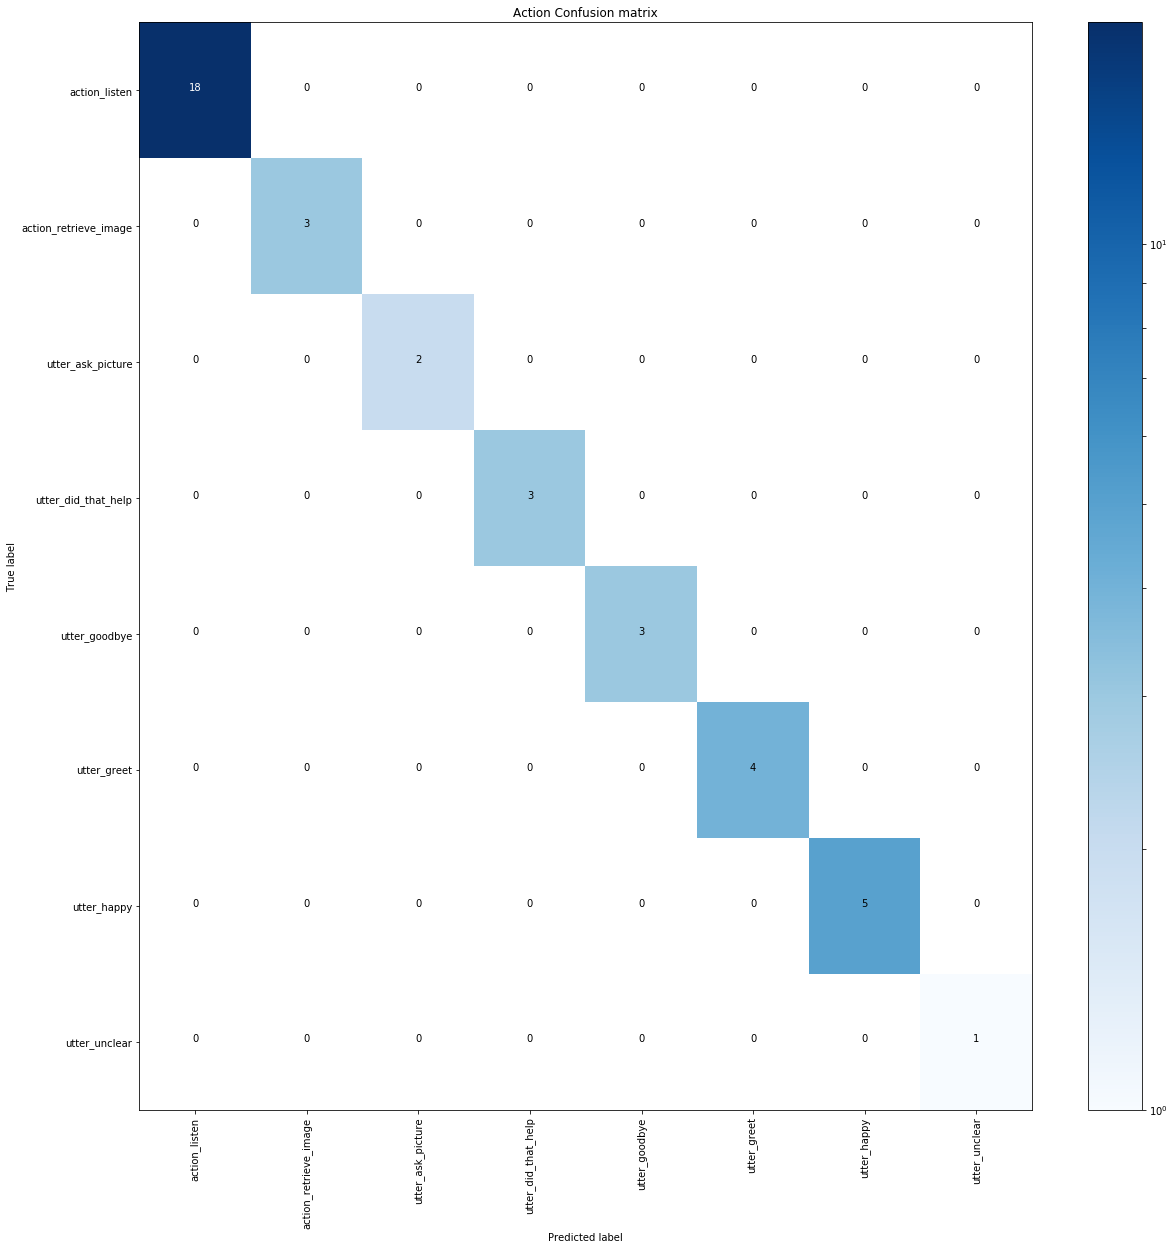

In [103]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")

### Interactive learning
Unfortunately, this doesn't work in jupyter yet. Hence, we going to do this on the command line. [The repository](https://github.com/tmbo/rasa-demo-pydata18)  contains a makefile with the instructions to run the interactive learning. So go ahead and run `make interactive` on the commandline (make sure your shell is in the righht virtual env).